# Classifying Exoplanets

For satellite missions, NASA needs to be able to process tons and tons of information received by satellites efficiently and effectively. We'll see one approach as to help NASA classify exoplanet stars by using modern machine learning techniques! How better to learn than use raw data from one of NASA's satellites?


The focus of this notebook is classifying exoplanet stars. We'll be:
*   Preprocessing the dataset for the ML models
*   Implementing different ML architectures to see which one performs best
*   Using data augmentation to improve our models' performance!

## Exoplanet Classification




Previously, we were able to visualize data of the training set from Kepler. Now that we better understand the data that we're working with, we can begin to dive into how we can train a computer to classify exoplanet stars, and the difficulties faced when doing so.

We can make use of different architectures and models to explore the best options for classifying exoplanet stars. Our explorations will also help us build intuition of how to analyze and use raw data from a satellite to help plan future missions exploring the abyss that is space around us. Is there life elsewhere? Right now we're not too sure, but identyfying and analyzing exoplanets can help us to better understand where we're most likely to find life!

In [ ]:
%tensorflow_version 2.x
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('exoTrain.csv')
df_train.LABEL = df_train.LABEL -1
df_test = pd.read_csv('exoTest.csv')
df_test.LABEL = df_test.LABEL - 1

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
--2023-07-02 02:38:30--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [application/octet-stream]
Saving to: ‘exoTrain.csv’

exoTrain.csv        100%[===================>] 250.08M  22.6MB/s    in 12s     

2023-07-02 02:38:42 (21.3 MB/s) - ‘exoTrain.csv’ saved [262223348/262223348]

--2023-07-02 02:38:42--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.

## Understanding our Data



### Data Visualization



In [ ]:
print("df_train len:", len(df_train))
print("df_test len:", len(df_test))
print("first 5 values of df train\n")
df_train.head()

df_train len: 5087
df_test len: 570
first 5 values of df train



,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


#### Comparing Flux Curves for Exoplanets vs. Non-Exoplanets

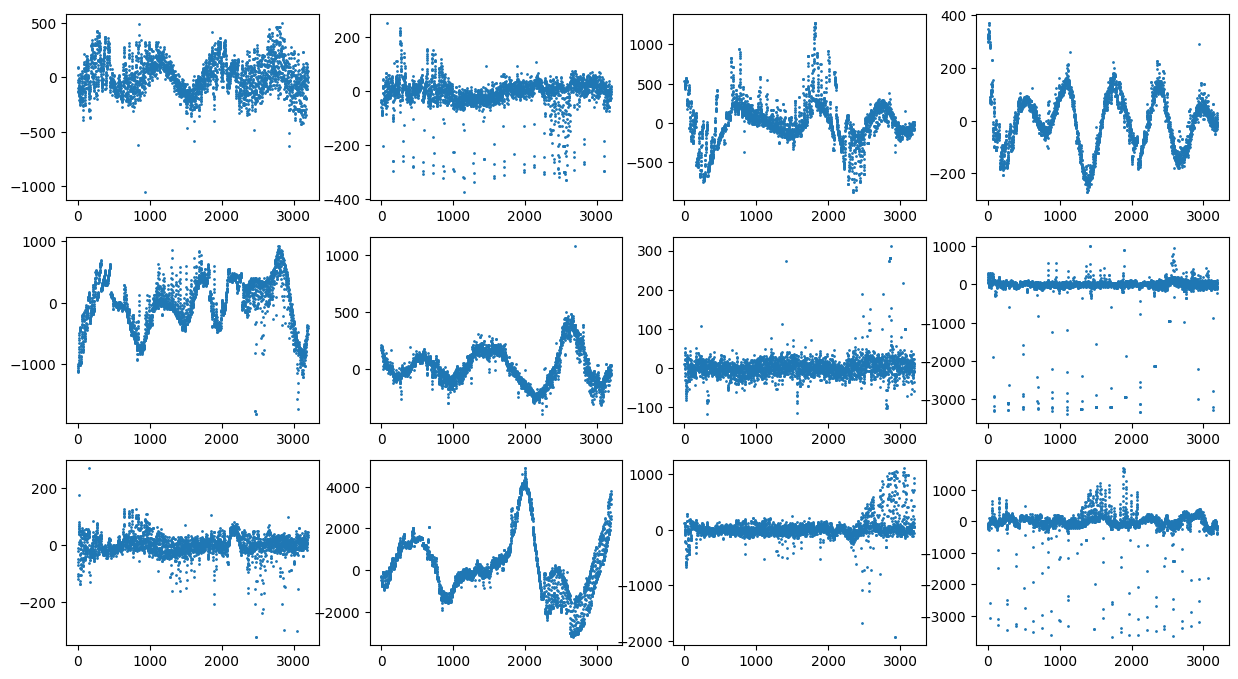

In [ ]:
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL'] == 1].iloc[i,1:],s=1)

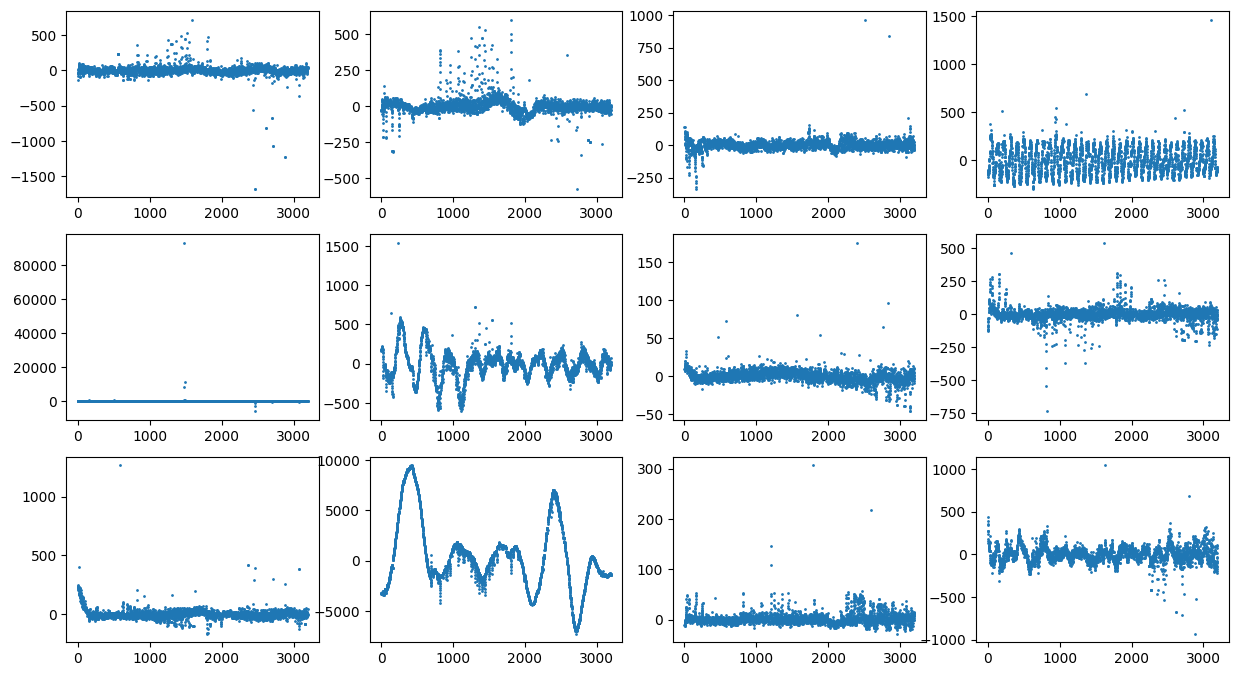

In [ ]:
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL']==0].iloc[i,1:],s=1)

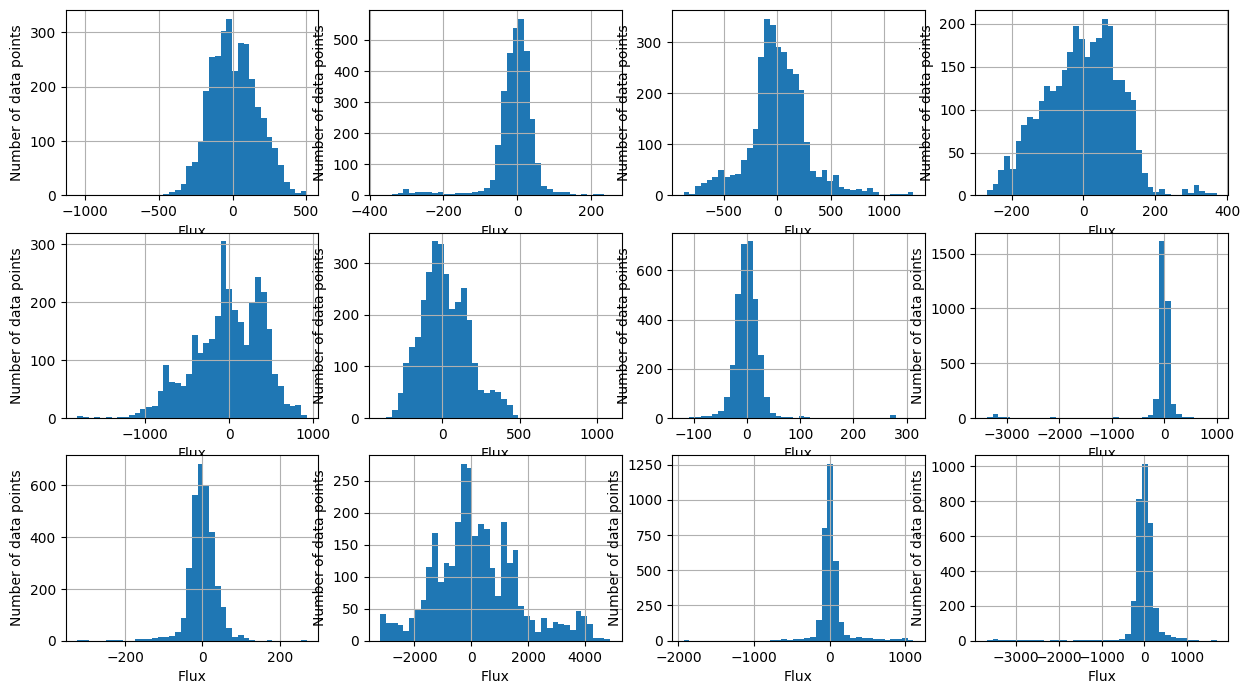

In [ ]:
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    plt.xlabel("Flux")
    plt.ylabel("Number of data points")
    df_train[df_train['LABEL']==1].iloc[i,1:].hist(bins=40)

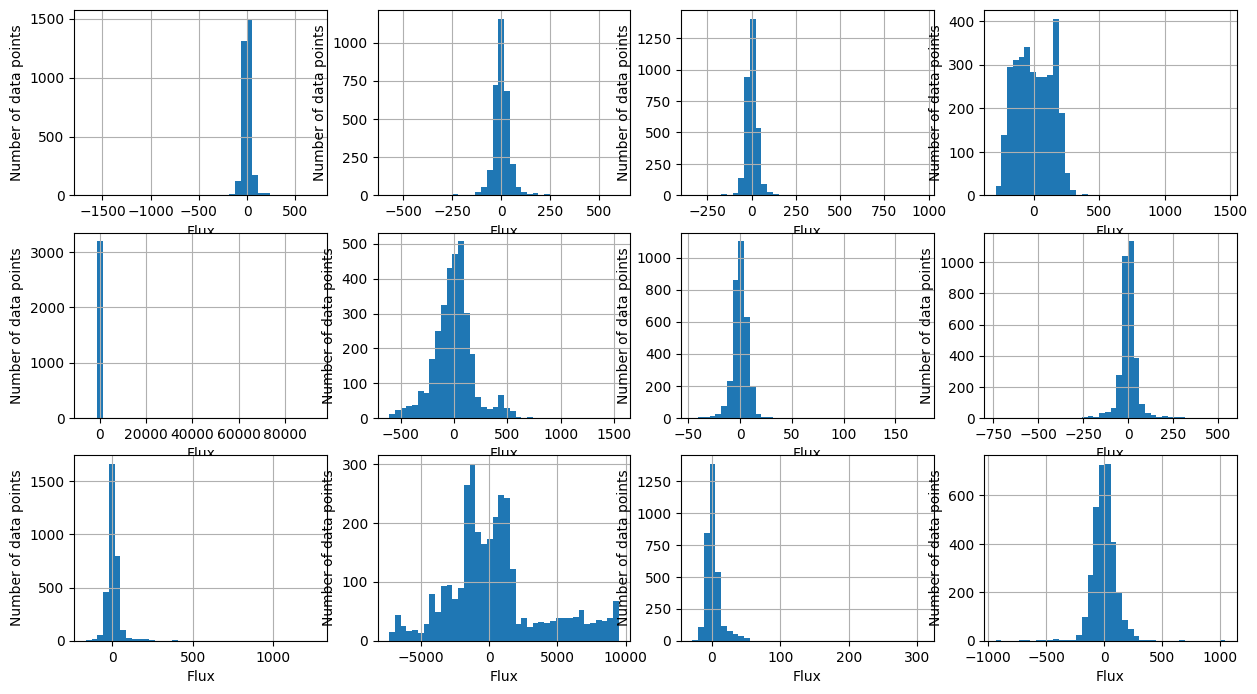

In [ ]:
# Histogram of Non-Exoplanet
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    plt.xlabel("Flux")
    plt.ylabel("Number of data points")
    df_train[df_train['LABEL']==0].iloc[i,1:].hist(bins=40)

### Counting Exoplanets



In [ ]:
#YOUR CODE HERE
train_with_exoplanet_samples = df_train.loc[df_train['LABEL'] == 1]
train_with_non_exoplanet_samples = df_train.loc[df_train['LABEL'] == 0]

print("exoplanet samples in train:", len(train_with_exoplanet_samples))
print("non-exoplanet samples in train:", len(train_with_non_exoplanet_samples))

test_with_exoplanet_samples = df_test.loc[df_test['LABEL'] == 1]
test_with_non_exoplanet_samples = df_test.loc[df_test['LABEL'] == 0]

print("exoplanet samples in test:", len(test_with_exoplanet_samples))
print("non-exoplanet samples in test:", len(test_with_non_exoplanet_samples))

exoplanet samples in train: 37
non-exoplanet samples in train: 5050
exoplanet samples in test: 5
non-exoplanet samples in test: 565


In [ ]:
print("df_train percent:", len(train_with_exoplanet_samples)/ len(df_train))
print("df_test percent:", len(test_with_exoplanet_samples)/ len(df_test))

df_train percent: 0.007273442107332416
df_test percent: 0.008771929824561403


## Classification with KNN



In [ ]:

def analyze_results(model, train_X, train_y, test_X, test_y):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    train_y : array-like of shape (n_samples,)
    Target values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    test_y : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    ConfusionMatrixDisplay.from_estimator(model,train_X,train_y)
    plt.show()
    print("Testing:")
    ConfusionMatrixDisplay.from_estimator(model,test_X,test_y)

def reset(train,test):
    train_X = train.drop('LABEL', axis=1)
    train_y = train['LABEL'].values
    test_X = test.drop('LABEL', axis=1)
    test_y = test['LABEL'].values
    return train_X,train_y,test_X,test_y

train_X,train_y,test_X,test_y = reset(df_train, df_test)

In [ ]:

n_neighbors = 5

model = KNeighborsClassifier(n_neighbors=n_neighbors)

In [ ]:
# Train the model
model.fit(train_X, train_y)

KNeighborsClassifier()

In [ ]:
# Calculate the predictions and accuracies on train_X and test_X
# using our trained model

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
print(accuracy_score(train_y, train_predictions))
print(accuracy_score(test_y, test_predictions))
####################

0.9931197169254964
0.9912280701754386


#### Confusion Matrices

Confusion Matrices are helpful in understanding how our model's doing and the kinds of biases it might have - even if it has a high accuracy.

-------------------------------------------
Model Results

Training:


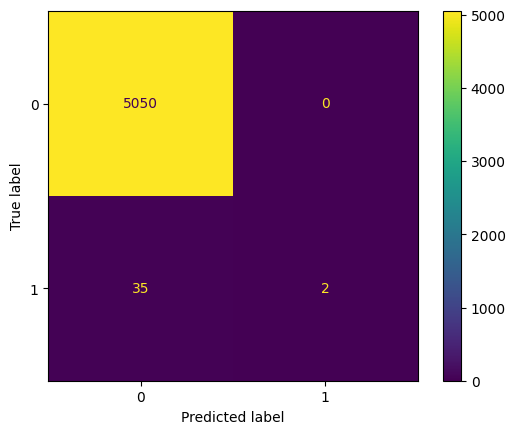

Testing:


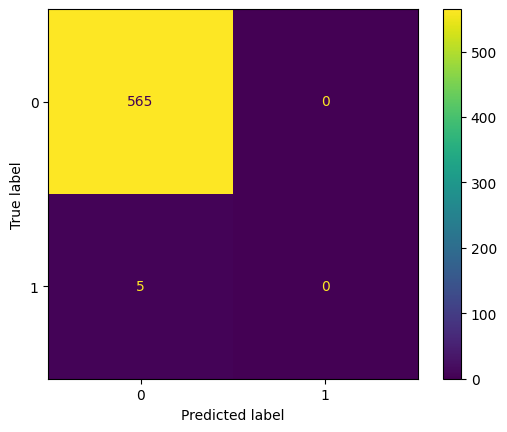

In [ ]:
#Analyze the KNN model
analyze_results(model=model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)



##Logistic Regression

In [ ]:

max_iter = 1000
model = LogisticRegression(max_iter=max_iter)

0.9260861018281895
0.6368421052631579
-------------------------------------------
Model Results

Training:


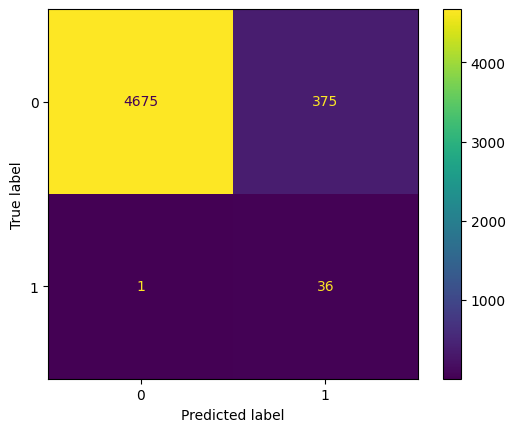

Testing:


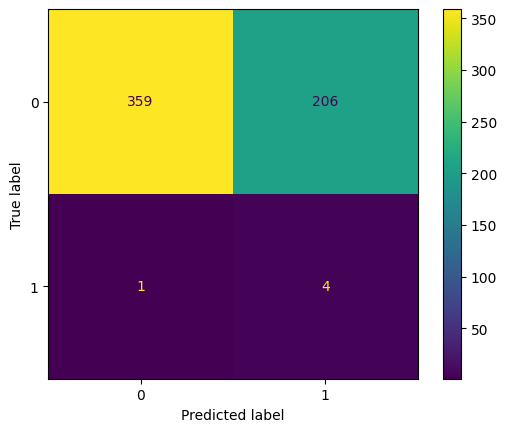

In [ ]:
model.fit(train_X, train_y)
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
print(accuracy_score(train_y, train_predictions))
print(accuracy_score(test_y, test_predictions))

analyze_results(model=model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)

## Exploring Other Models



0.9927265578926676
0.9736842105263158
-------------------------------------------
Model Results

Training:


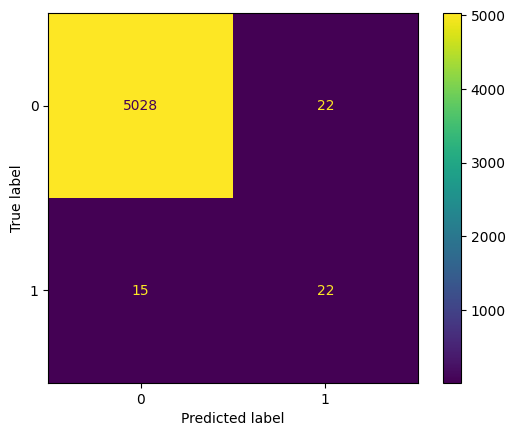

Testing:


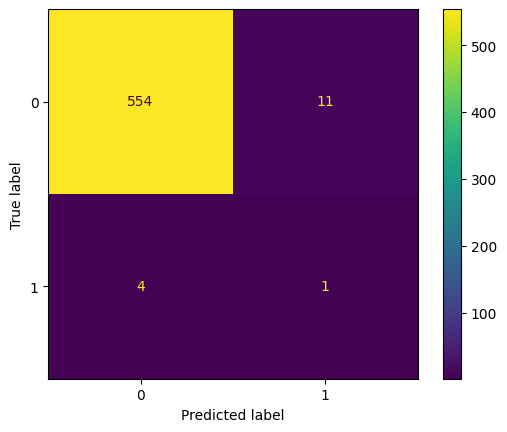

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

model.fit(train_X, train_y)
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
print(accuracy_score(train_y, train_predictions))
print(accuracy_score(test_y, test_predictions))

analyze_results(model=model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)

In [ ]:
#YOUR CODE HERE to experiment with creating and importing models!
from sklearn import DecisionTreeClassifier

model = tree.DecisionTreeClassifier()

model.fit(train_X, train_y)
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
print(accuracy_score(train_y, train_predictions))
print(accuracy_score(test_y, test_predictions))

analyze_results(model=model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)

ImportError: ignored

## Data Augmentation


In [ ]:

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    train_X = np.abs(np.fft.fft(df1, axis=1))
    test_X = np.abs(np.fft.fft(df2, axis=1))
    return train_X,test_X

def norm(df1,df2):
    train_X = normalize(df1)
    test_X = normalize(df2)
    return train_X,test_X

def robust(df1,df2):
    scaler = RobustScaler()
    train_X = scaler.fit_transform(df1)
    test_X = scaler.transform(df2)
    return train_X,test_X

How can the data can be improved. Here we'll further explore two points of previous concern:
1. Data having a high range of values
2. Data being heavily unbalanced (towards non-exoplanet stars)

In [ ]:

print("Value 1:", value_1 == 0.14)
print("Value 2:", value_2 == 0)
print("Value 3:", value_3 == 0.86)
print("Value 4:", value_4 == 1.0)

Value 1: True
Value 2: True
Value 3: True
Value 4: True


In [ ]:
def norm(train_X, test_X):
    """
    Helper function to normalize inputs train_X and test_X
    """
    norm_train_X=normalize(train_X)
    norm_test_X=normalize(test_X)
    return norm_train_X, norm_test_X

In [ ]:
fourier_train_X, fourier_test_X = fourier(train_X, test_X)
savgol_train_X, savgol_test_X = savgol(fourier_train_X, fourier_test_X)

#####TODO#########
norm_train_X, norm_test_X = norm(savgol_train_X, savgol_test_X)
##################

robust_train_X, robust_test_X = robust(norm_train_X, norm_test_X)

### Data Augmentation with SMOTE

Now to tackle the problem of having an imbalanced dataset! The concept that we'll use to approach this is by synthesizing new data based off of our existing to create a more balanced dataset. Essentially, we'll be creating new datapoints to have more exoplanet samples.

We'll accomplish this by using SMOTE.

SMOTE generates new data for the minority class to help balance the dataset, and to better help define classifcation regions - so the model doesn't always predict the majority class.

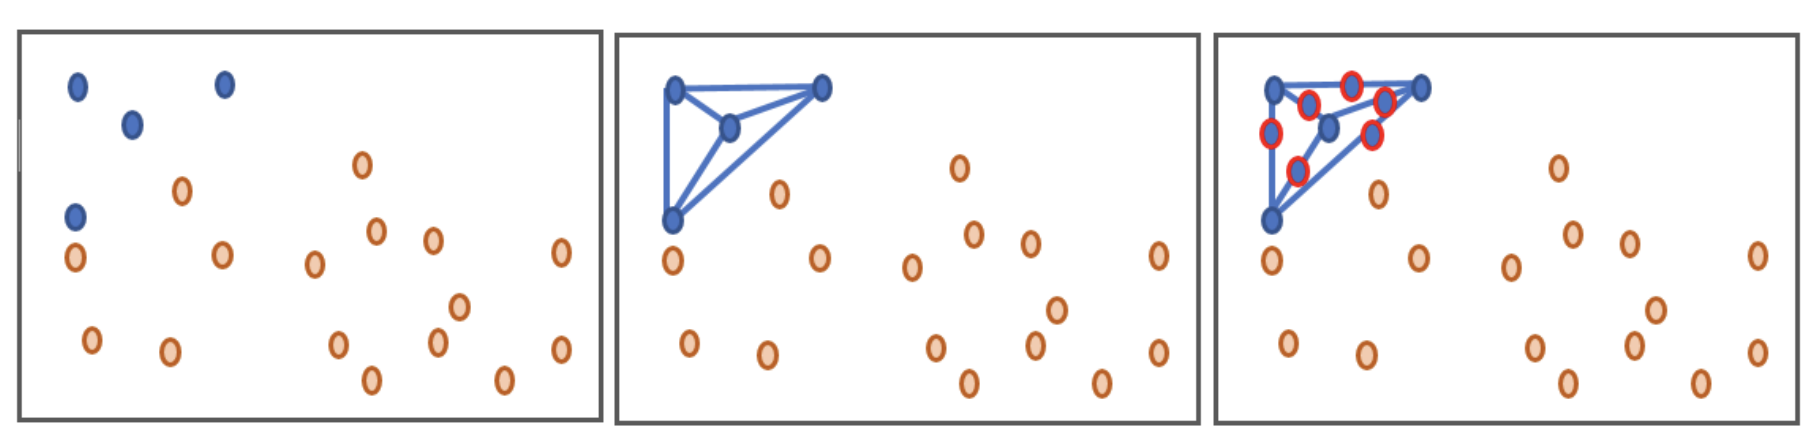

You can learn more about SMOTE [here](https://datasciencecampus.github.io/balancing-data-with-smote/).

In [ ]:
smote_train_X, smote_train_y = None, None

In [ ]:
aug_train_X, new_X_test_data, aug_train_y, new_y_test_data = train_test_split(smote_train_X, smote_train_y, test_size=0.3)
aug_test_X = np.concatenate((robust_test_X, new_X_test_data), axis=0)
aug_test_y = np.concatenate((test_y, new_y_test_data), axis=0)

In [ ]:
def visualize_data(X, y, indicies):
  stars = indicies

  fig = plt.figure(figsize=(24,500))
  x = np.array(range(3197))
  for i in range(0,len(stars)):
      ax = fig.add_subplot(100,5,1+i)
      ax.set_title('Data '+"I:"+str(stars[i])+" Label:"+str(y[stars[i]]))
      ax.scatter(x, X[stars[i],:],s=1)

robust_train_y_with_exoplanet_indicies = train_y.nonzero()[0]
robust_train_y_with_no_exoplanet_indicies = (train_y-1).nonzero()[0]

aug_train_y_with_exoplanet_indicies = aug_train_y.nonzero()[0]
aug_train_y_with_no_exoplanet_indicies = (aug_train_y-1).nonzero()[0]

In [ ]:
# Visualize old data containing exoplanets
print("Orginal, newly modified data with exoplanets:")
visualize_data(robust_train_X, train_y, robust_train_y_with_exoplanet_indicies[:5])

In [ ]:
# Visualize newly generated data containing exoplanets
print("Augmented data with Exoplanets:")
visualize_data(aug_train_X, aug_train_y, aug_train_y_with_exoplanet_indicies[:5])

In [ ]:
# Visualize original, modified data with no Exoplanets
print("Orginal, newly modified data with no exoplanets:")
visualize_data(robust_train_X, train_y, robust_train_y_with_no_exoplanet_indicies[:5])

In [ ]:
#Visualize newly generated data containing no exoplanets
print("Augmented data with no Exoplanets:")
visualize_data(aug_train_X, aug_train_y, aug_train_y_with_no_exoplanet_indicies[:5])